Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Согласно поставленной задачи, нам нужно качественно и быстро определять предпологаемую цену автомобиля. Для того что бы деллать это качественно нужно хорошо предобработать данные и удалить ошибочные или не корректные данные. При анализе будем руводствоваться общепринятыми стандартами или известными ззначениями.
1. Обще ознакомление с данными
2. Анализ целевого признака
3. Изучение признаков, удаление некачественных данных
    - Категориальные 
        
    - Количественные
4. Анализ пропусков
5. Формирование датасетов для обучения.
    

# 1. Подготовка данных

#import

In [3]:
!pip install catboost

     |████████████████████████████████| 65.7MB 73kB/s 


In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import Pool, cv
import time
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/car_price/autos.csv')

In [8]:
#check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.shape

(354369, 16)

In [10]:
# просмотр данных
df.head(10) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [11]:
# Приведем название признаков к нижнему регистру
df.columns = map(str.lower, df.columns)
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### Анализ  целевого признака

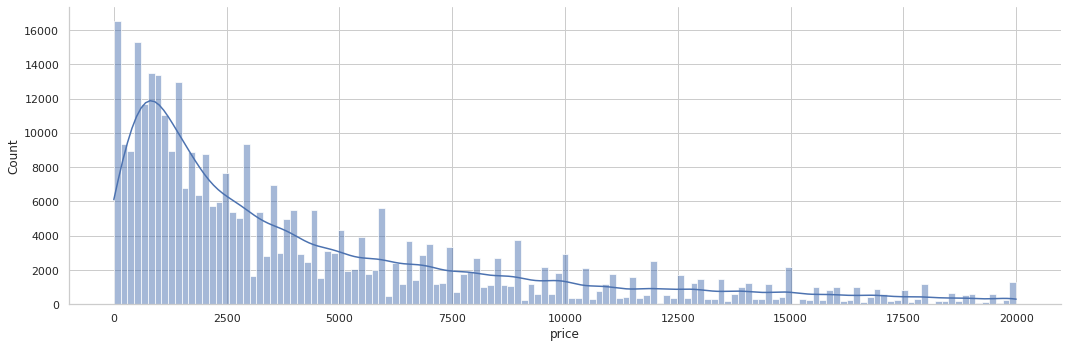

In [24]:
sns.set_theme(style="whitegrid")
g = sns.displot(data=df.price, aspect=3,kde=True).set_titles("Price")

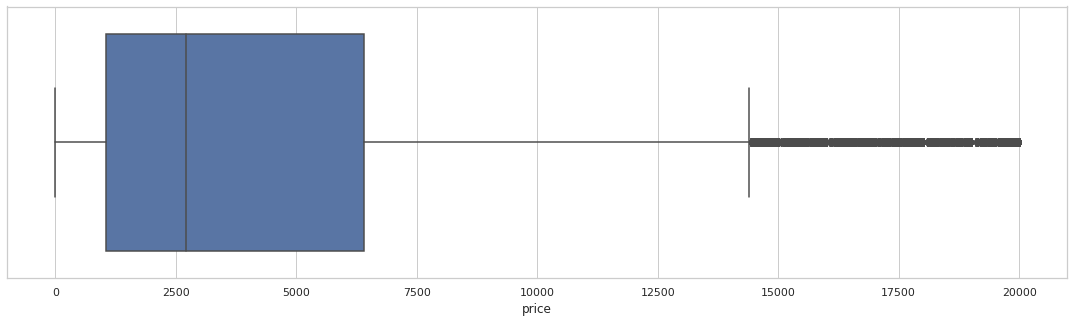

In [38]:
plt.figure(figsize=(19, 5))
sns.boxplot(x=df.price)

Много нулевых занчений и близких к 0 , удалим. Для нашей задачи нулевая стоимость авто не годится, будем считать, что минимальная стоимость авто 100 евро, Максимальную цену оставим без изменений.Далее возможно внес корректировки. Есть предположение, что когда продавец заполняет поле 0 или другой не  корректной величиной (1,2,3 999 и т.д.), то он просто не знает этого параметра. 

In [39]:
df.drop(df.loc[df['price'] < 100].index, inplace=True)

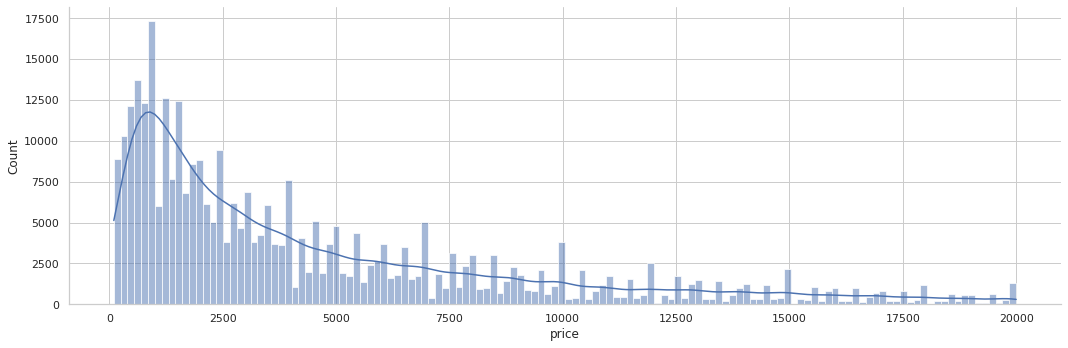

In [41]:
g = sns.displot(data=df.price, aspect=3,kde=True).set_titles("Price")

In [42]:
df['price'].describe()

count    341055.000000
mean       4588.861052
std        4514.844700
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Перейдем к признакам, проверим сначала категориальные, затем колличественные избавимся от выбросов и некорректно указанных данных, а после уже проверим кол-во пустых значений.

In [43]:
df.head(5)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Проверим категориальные признаки 

#### Коропка передач

In [44]:
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

#### Модель автомобиля

In [57]:
df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
     

#### Тип топлива

In [58]:
df.fueltype.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

#### Производитель

In [59]:
df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'sonstige_autos', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'trabant', 'land_rover', 'lada'], dtype=object)

Похоже что нечего критичного кроме nan нет. 

### Проверим количественные признаки

#### Год регистрации автомобиля 

Печально, много неверных данных.

In [70]:
df.registrationyear.describe()

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

In [72]:
#найдем реальный минимальный год регистрации автомобиля
df.query('registrationyear < 1999 and registrationyear >1800')['registrationyear'].min()


1910

In [79]:
# Удалим года регистрации со значениями  меньше 1910 и старше 2016 года 
df.drop(df.query('registrationyear > 2016 or registrationyear < 1910').index,inplace=True)

In [80]:
df.registrationyear.describe()

count    327325.000000
mean       2002.624749
std           6.860012
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64

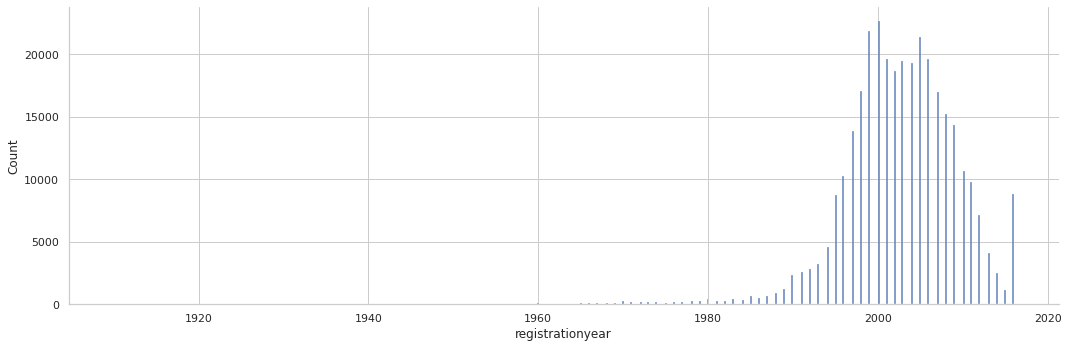

In [81]:
sns.displot(df.registrationyear,aspect=3)

Теперь посмотрим на мощность

In [85]:
df.power.max()

20000

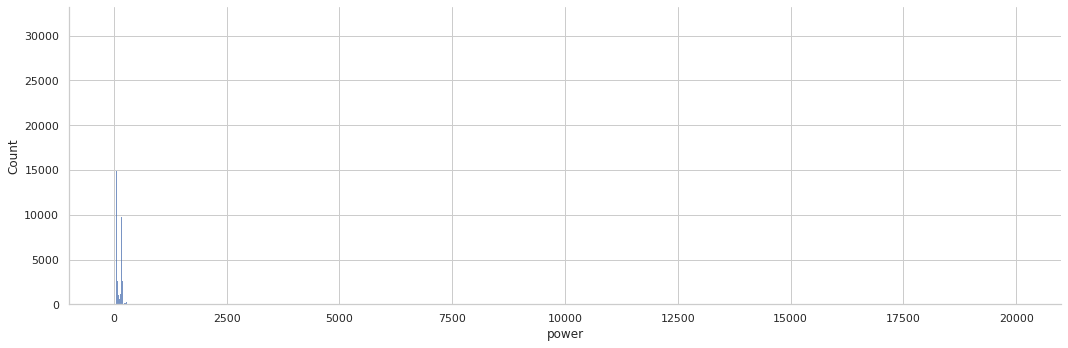

In [83]:
sns.displot(df.power,aspect=3)

In [86]:
df.power.describe()

count    327325.000000
mean        112.338596
std         185.284657
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Не машины, а ракеты. Мощность среднестатистического автомобиля схожа с нашим средним 111 л.с, есть автобусы с мощностью до 500 л.с. Удалим данные с мощностью более 700 л.с. - это уже уникальные ТС.
У нас есть еще нулевые значения мощности. Вероятно здесь похожая ситуация как и с ценой автомобиля.
За минимально возможную величину возьмем 9 л.с. 

In [87]:
df.drop(df.query('power > 700 or power < 9').index, inplace=True)

In [88]:
df.power.describe()

count    295219.000000
mean        120.767440
std          54.035429
min           9.000000
25%          76.000000
50%         111.000000
75%         150.000000
max         700.000000
Name: power, dtype: float64

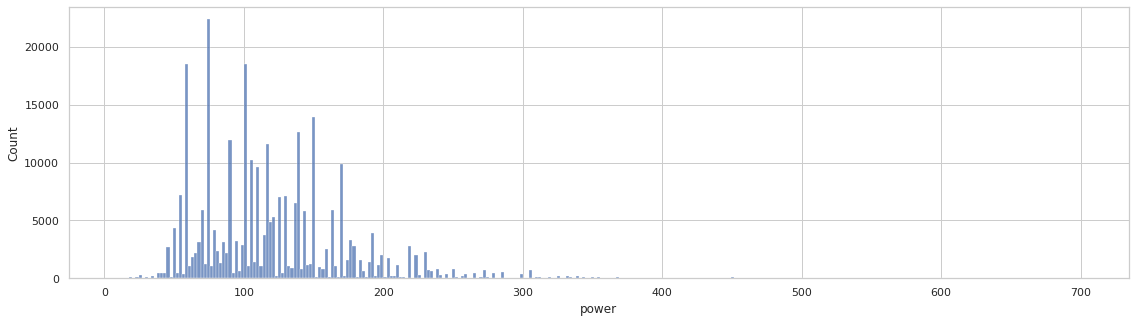

In [96]:
plt.figure(figsize=(19,5))
sns.histplot(df.power)

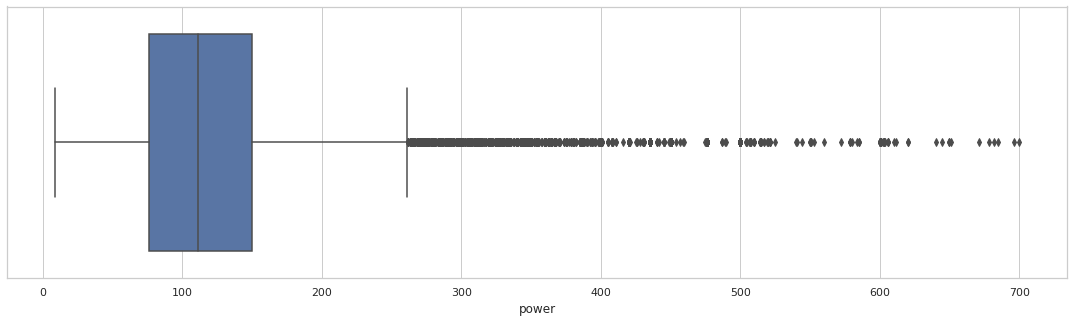

In [97]:
plt.figure(figsize=(19,5))
sns.boxplot(data=df, x='power')

#### Пробег

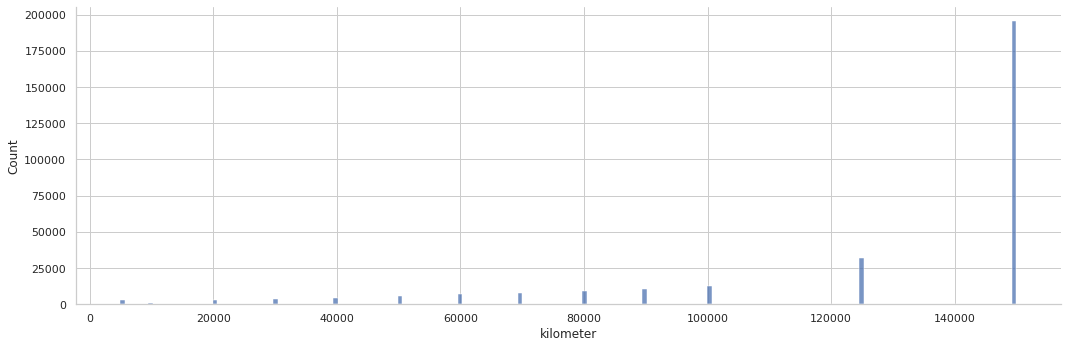

In [100]:
sns.displot(df.kilometer,aspect=3)

In [ ]:
df.kilometer.describe()

count    295219.000000
mean     128303.090248
std       36714.971982
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Признак километража очень странно выглядит, вероятно есть операция округления значений при подаче обьявлений

<Figure size 1368x360 with 0 Axes>

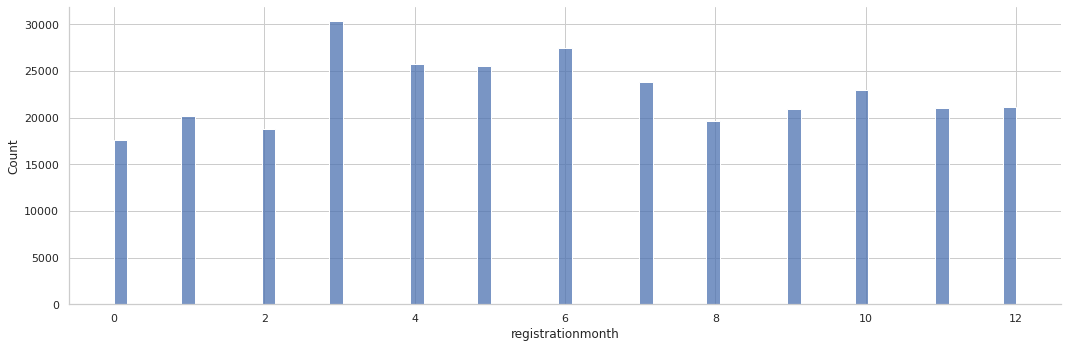

In [103]:
sns.displot(df.registrationmonth,aspect=3)

Нулевой месяц, возможно это авто снятое с учета, тогда registrationyear скорее год выпуска. Пока оставим без изменений.

In [106]:
df.shape

(295219, 16)

In [107]:
# check for NuN or empty
df.isna().mean()


datecrawled          0.000000
price                0.000000
vehicletype          0.036654
registrationyear     0.000000
gearbox              0.017811
power                0.000000
model                0.037061
kilometer            0.000000
registrationmonth    0.000000
fueltype             0.051904
brand                0.000000
notrepaired          0.143869
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

Пропуски: 
- vehicletype - тип кузова 9%
- gearbox  тип КП 4%
- model - 4% 
- fueltype - тип топлива 8%
- notrepaired - признак ремонта 18%

Метрики категориальные. Попробуем сделать 2 дата сета.
 1. полностью удалим данные,  хотя удалять 15% это совсем не правильно. Но в рамках эксперемента можно)
 2. заполним пустышки "other", а затем сделаем процедуру "OrdinalEncoder"
 

### Временные признаки, дата

In [108]:
df.head(1)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


У нас есть три временных признака, дата скачивания анкеты (datecrawled), дата создания обьявления (datecreated)  и дата последней активности (lastseen) посмотрим на самые старые или новые обьявления. 

In [109]:
df[['datecrawled', 'datecreated', 'lastseen']].min()

datecrawled    2016-03-05 14:06:22
datecreated    2015-03-20 00:00:00
lastseen       2016-03-05 14:15:08
dtype: object

In [110]:
df[['datecrawled', 'datecreated', 'lastseen']].max()

datecrawled    2016-04-07 14:36:58
datecreated    2016-04-07 00:00:00
lastseen       2016-04-07 14:58:51
dtype: object

In [111]:
df['yearcreated'] = pd.DatetimeIndex(df['datecreated']).year

In [112]:
df['monthcreated'] = pd.DatetimeIndex(df['datecreated']).month

В нашем распоряжении срез данных примерно за год и три временных признака, но важным по сути является только дата создания обьявления, создадим 2 новых признака. Год и месяц публикации

In [114]:
df.head(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,yearcreated,monthcreated
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,3
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,3
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,3


#### Почтовый индекс

Почтовый индекс значимый признак, отражающий географическое положение обьявления, что вв свою очередь влияет на цену автомобиля.
Проверим уникальность индексов и присвоим им ранг. Возможно это облегчит задачу модели.

In [115]:
# проверка уникальности индексов
len(df['postalcode'].unique())

8116

In [116]:
df['postalrank'] = df['postalcode'].rank(pct=max)

In [117]:
df.head(2)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,yearcreated,monthcreated,postalrank
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,3,0.710339
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,3,0.924730


In [118]:
# Удалим  признаки даты 
df.drop(['datecrawled', 'datecreated', 'lastseen','numberofpictures'],axis=1 ,inplace=True)

In [119]:
df.corr()

,price,registrationyear,power,kilometer,registrationmonth,postalcode,yearcreated,monthcreated,postalrank
price,1.000000,0.481021,0.506217,-0.388892,0.067679,0.064415,-0.004414,0.015664,0.064683
registrationyear,0.481021,1.000000,0.135802,-0.287921,0.046820,0.029403,-0.001554,0.000500,0.029667
power,0.506217,0.135802,1.000000,0.104346,0.041344,0.054016,-0.000275,0.002578,0.054569
kilometer,-0.388892,-0.287921,0.104346,1.000000,-0.014919,-0.010198,0.004751,-0.002722,-0.011170
registrationmonth,0.067679,0.046820,0.041344,-0.014919,1.000000,0.002165,0.003145,-0.002819,0.002421
postalcode,0.064415,0.029403,0.054016,-0.010198,0.002165,1.000000,0.002194,0.009980,0.997360
yearcreated,-0.004414,-0.001554,-0.000275,0.004751,0.003145,0.002194,1.000000,-0.175954,0.001912
monthcreated,0.015664,0.000500,0.002578,-0.002722,-0.002819,0.009980,-0.175954,1.000000,0.010125
postalrank,0.064683,0.029667,0.054569,-0.011170,0.002421,0.997360,0.001912,0.010125,1.000000


In [120]:
# Удалим  признаки даты и почтового индекса
df.drop(['postalcode','registrationmonth','yearcreated','monthcreated'],axis=1 ,inplace=True)

In [167]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,postalrank
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0.710339
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,0.924730
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0.930518
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0.635552
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0.293530
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no,0.514105
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,0.976816
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0.192315
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,0.891321


#### Порядковое кодирование и стандартизация

In [196]:
class myTransform(BaseEstimator, TransformerMixin):
  def __init__(self, clr):
    self.clr = clr 
  

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    temp = X.copy()

    if self.clr:
      temp = temp.dropna()
    else: 
      temp.fillna(value="other", inplace=True)  
    
    return temp

In [197]:

df_clear = myTransform(clr=False)

In [198]:
df_clear

myTransform(clr=False)

In [199]:

newdf = df_clear.fit_transform(df)

In [200]:
newdf

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,postalrank
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,0.710339
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other,0.924730
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0.930518
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0.635552
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0.293530
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,other,2016,auto,150,159,150000,other,alfa_romeo,no,0.514105
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,0.976816
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0.192315
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,0.891321


In [ ]:
df_replace = df.copy()

In [ ]:
df_replace.isna().mean()

price               0.000000
vehicletype         0.036654
registrationyear    0.000000
gearbox             0.017811
power               0.000000
model               0.037061
kilometer           0.000000
fueltype            0.051904
brand               0.000000
notrepaired         0.143869
postalrank          0.000000
dtype: float64

In [ ]:
df_replace.fillna(value="other",inplace=True)

In [ ]:
df_replace.isna().mean()

price               0.0
vehicletype         0.0
registrationyear    0.0
gearbox             0.0
power               0.0
model               0.0
kilometer           0.0
fueltype            0.0
brand               0.0
notrepaired         0.0
postalrank          0.0
dtype: float64

In [ ]:
df_clear = pd.get_dummies(df_clear, drop_first=True)

,price,registrationyear,power,kilometer,postalrank,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
3,1500,2001,75,150000,0.930518,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0.635552,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0.293530,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,0.713408,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2000,2004,105,150000,0.974468,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,1490,1998,50,150000,0.477403,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
354359,7900,2010,140,150000,0.788621,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
354362,3200,2004,225,150000,0.976816,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,0.192315,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
df_clear.shape

(232591, 306)

In [ ]:
df_replace = pd.get_dummies(df_replace, drop_first=True)

In [ ]:
df_replace

,price,registrationyear,power,kilometer,postalrank,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_other,notrepaired_yes
1,18300,2011,190,125000,0.710339,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0.924730,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0.930518,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0.635552,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0.293530,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0.514105,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0.976816,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,0.192315,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0.891321,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_replace.shape

(295219, 309)

### Итог
Проведена предобработка данных.
Удалены выборосы.
Получили 3 дата сета. Было удалено порядка 19% процентов данных в случае формирования чистого датасета без выбросов и пропусков и около 12% при формировании датасета очистив его только от выбросов.



<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>отличная работа по разделу! как настоящий аналитик - два подхода к данным)

# 2. Обучение моделей

### Подготовка данных к обучению

#### Разбивка датасетов

In [ ]:
# выборка с "чистыми данными"
df_clear_features = df_clear.drop('price', axis=1)
df_clear_target = df_clear['price']

In [ ]:
# выборка с данными, в которых NuN заменены на other
df_replace_features = df_replace.drop('price', axis=1)
df_replace_target = df_replace['price']

### Подготовка тренеровочных и тестовых латасетов

In [ ]:
df_clear_train_x, df_clear_test_x, df_clear_train_y, df_clear_test_y = train_test_split(df_clear_features, 
                                                                                         df_clear_target, 
                                                                                         test_size=0.20, 
                                                                                         random_state=42)

In [ ]:
df_replace_train_x, df_replace_test_x, df_replace_train_y, df_replace_test_y = train_test_split(df_replace_features,
                                                                                                 df_replace_target, 
                                                                                                 test_size=0.20, 
                                                                                                 random_state=42)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>ОК

### Обучение моделей

Подберем параметры моделей используя два датасета, подбор будем делать на 10 итерациях, затем на подобранных параметрах увеличим количество итераций

#### catboost датасет df_replace

In [ ]:
catboost_replace = {}

In [ ]:
grid_model_replace = CatBoostRegressor(loss_function="RMSE", iterations=5, random_state=42)

In [ ]:
grid = {
        'learning_rate': [0.1,0.5,1],
        'depth': [10,15]
       }

In [ ]:
cv_dataset_replace = Pool(data=df_replace_train_x,
                  label=df_replace_train_y)
cv_test_replace = Pool(data=df_replace_test_x, label = df_replace_test_y)

In [ ]:
start = time.time()
grid_model_replace.grid_search(grid, X=cv_dataset_replace, 
                                       plot=False,
                                       cv=3,
                                       shuffle=True,
                                       train_size=0.8,
                                       verbose=10
                                      )
end = time.time()
grid_time_for_replace = end - start

0:	loss: 4417.1674566	best: 4417.1674566 (0)	total: 7.97s	remaining: 39.9s
5:	loss: 1848.7980445	best: 1848.7980445 (5)	total: 32.5s	remaining: 0us
Estimating final quality...


In [ ]:
catboost_replace['grid_time'] = str(timedelta(seconds=grid_time_for_replace))

In [ ]:
catboost_replace['grid_score'] = grid_model_replace.get_best_score()['learn']['RMSE']

In [ ]:
grid_model_replace.get_params()

{'iterations': 5,
 'loss_function': 'RMSE',
 'random_state': 42,
 'depth': 15,
 'learning_rate': 1}

In [ ]:
model_for_replace = CatBoostRegressor(loss_function="RMSE", iterations=70, depth=15, 
                          learning_rate=1,
                          l2_leaf_reg=1, 
                          random_state=42)

In [ ]:
start = time.time()

model_for_replace.fit(df_replace_train_x, df_replace_train_y,eval_set = cv_test_replace, verbose=10)

end = time.time()
fit_time_for_replace = end - start

0:	learn: 2182.8558189	test: 2183.9244636	best: 2183.9244636 (0)	total: 1.39s	remaining: 1m 36s
10:	learn: 1592.1461383	test: 1694.1439809	best: 1694.1439809 (10)	total: 15.7s	remaining: 1m 24s
20:	learn: 1469.8310043	test: 1656.7762399	best: 1656.7762399 (20)	total: 30.2s	remaining: 1m 10s
30:	learn: 1398.6978067	test: 1643.4087132	best: 1643.4087132 (30)	total: 44.7s	remaining: 56.3s
40:	learn: 1335.9834727	test: 1642.1391629	best: 1640.4466577 (39)	total: 59.2s	remaining: 41.9s
50:	learn: 1278.8444481	test: 1640.9510514	best: 1640.3708265 (48)	total: 1m 13s	remaining: 27.5s
60:	learn: 1229.9297364	test: 1643.1485659	best: 1640.3708265 (48)	total: 1m 28s	remaining: 13.1s
69:	learn: 1187.0646631	test: 1645.6981633	best: 1640.3708265 (48)	total: 1m 41s	remaining: 0us

bestTest = 1640.370827
bestIteration = 48

Shrink model to first 49 iterations.


In [ ]:
catboost_replace['fit_time'] = str(timedelta(seconds=fit_time_for_replace))

In [ ]:
catboost_replace['fit_score']  = model_for_replace.get_best_score()['validation']['RMSE']

In [ ]:
catboost_replace['model'] = model_for_replace

In [ ]:
catboost_replace

{'grid_time': '0:01:14.810871',
 'grid_score': 1737.5142517374036,
 'fit_time': '0:01:51.018680',
 'fit_score': 1640.3708265324594,
 'model': <catboost.core.CatBoostRegressor at 0x7f4c2a56d190>}

 #### catboost  датасет df_clear

In [ ]:
catboost_clear = {}

In [ ]:
cv_dataset_clear = Pool(df_clear_train_x, label = df_clear_train_y)
cv_test_clear = Pool(df_clear_test_x, df_clear_test_y)

In [ ]:
grid_model_clear = CatBoostRegressor(loss_function="RMSE", iterations=5, random_state=42)

In [ ]:
start = time.time()
grid_model_clear.grid_search(grid, X=cv_dataset_clear, 
                                       plot=False,
                                       cv=3,
                                       shuffle=True,
                                       train_size=0.8,               
                                       verbose=10
                                      )
end = time.time()
time_grid_for_clear = end - start

0:	loss: 4638.2293262	best: 4638.2293262 (0)	total: 6.82s	remaining: 34.1s
5:	loss: 1818.1384495	best: 1818.1384495 (5)	total: 28.6s	remaining: 0us
Estimating final quality...


In [ ]:
catboost_clear['grid_time'] = str(timedelta(seconds=time_grid_for_clear))

In [ ]:
catboost_clear['grid_score'] = grid_model_clear.get_best_score()['learn']['RMSE']

In [ ]:
grid_model_clear.get_params()

{'iterations': 5,
 'loss_function': 'RMSE',
 'random_state': 42,
 'depth': 15,
 'learning_rate': 1}

In [ ]:
model_for_clear = CatBoostRegressor(loss_function="RMSE", iterations=60, depth=15, 
                          learning_rate=1,
                          l2_leaf_reg=1, 
                          random_state=42)

In [ ]:
start = time.time()
model_for_clear.fit(df_clear_train_x, df_clear_train_y, eval_set = cv_test_clear, verbose=10)
end = time.time()
fit_time = end - start

0:	learn: 2186.9550459	test: 2187.3748247	best: 2187.3748247 (0)	total: 1.28s	remaining: 1m 15s
10:	learn: 1567.1458712	test: 1686.9026181	best: 1686.9026181 (10)	total: 15.4s	remaining: 1m 8s
20:	learn: 1444.8842753	test: 1643.6621195	best: 1643.6621195 (20)	total: 29.4s	remaining: 54.7s
30:	learn: 1371.1463195	test: 1631.3866508	best: 1631.3866508 (30)	total: 42.8s	remaining: 40s
40:	learn: 1298.4756353	test: 1628.2985220	best: 1628.2985220 (40)	total: 56s	remaining: 26s
50:	learn: 1249.4497915	test: 1625.2053835	best: 1625.2053835 (50)	total: 1m 9s	remaining: 12.3s
59:	learn: 1206.3159493	test: 1626.0129939	best: 1624.5805370 (53)	total: 1m 21s	remaining: 0us

bestTest = 1624.580537
bestIteration = 53

Shrink model to first 54 iterations.


In [ ]:
catboost_clear['fit_time'] = str(timedelta(seconds=fit_time))

In [ ]:
catboost_clear['fit_score'] = model_for_clear.get_best_score()['validation']['RMSE']

In [ ]:
catboost_clear['model'] = "Catboost"

In [ ]:
catboost_clear

{'grid_time': '0:01:06.866642',
 'grid_score': 1729.6254036106034,
 'fit_time': '0:01:28.752476',
 'fit_score': 1624.5805370308228,
 'model': 'Catboost'}

#### итог

In [ ]:
catboost_clear

{'grid_time': '0:01:06.866642',
 'grid_score': 1729.6254036106034,
 'fit_time': '0:01:28.752476',
 'fit_score': 1624.5805370308228,
 'model': 'Catboost'}

In [ ]:
catboost_replace

{'grid_time': '0:01:14.810871',
 'grid_score': 1737.5142517374036,
 'fit_time': '0:01:51.018680',
 'fit_score': 1640.3708265324594,
 'model': <catboost.core.CatBoostRegressor at 0x7f4c2a56d190>}

#### LGBM  модель

По рещультатам модели catboost модель LGBM будем обучать на чистом датасете  df_clear по аналогичному принципу

In [ ]:
del df

In [ ]:
del df_replace_train_x
del df_replace_test_x

In [ ]:
lgbm = {}

In [ ]:
params = {
    'n_estimators': [10],
    'learning_rate': [0.1,0.5,1],
    'max_depth': [25,40],
    'objective':['regression']
}

In [ ]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [ ]:
grid = GridSearchCV(lgb.LGBMRegressor(random_state=42), params, scoring=mse, cv=3)

In [ ]:
start = time.time()

grid.fit(df_clear_train_x, df_clear_train_y)

time_grid = time.time() - start

In [ ]:
lgbm['grid_time'] = str(timedelta(seconds=time_grid))

In [ ]:
lgbm['grid_score'] = (grid.best_score_*-1)**0.5

In [ ]:
grid.best_params_

{'learning_rate': 0.5,
 'max_depth': 25,
 'n_estimators': 10,
 'objective': 'regression'}

In [ ]:
lgbmr = lgb.LGBMRegressor(boosting_type='gbdt',objective= 'regression',learning_rate=0.5, 
                          max_depth=25,n_estimators=200,
                          eval_set=[(df_clear_test_x, df_clear_test_y)],
                          eval_metric='rmse', verbose=1,
                          random_state=42)

In [ ]:
start = time.time()
lgbmr.fit(df_clear_train_x, df_clear_train_y)
lgbm['fit_time']  = str(timedelta(seconds = time.time() - start))

In [ ]:
lgbm['fit_score'] = (grid.best_score_*-1)**0.5

In [ ]:
lgbm['model'] = 'LGBMRegressor'

In [ ]:
lgbm

{'grid_time': '0:01:00.765031',
 'grid_score': 1770.482753397451,
 'fit_time': '0:00:17.703767',
 'fit_score': 1770.482753397451,
 'model': 'LGBMRegressor'}

#### Линейная регрессия

In [ ]:
lin_r = {}

In [ ]:
df_clear_train_x.head(2)

,registrationyear,power,kilometer,postalrank,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
44871,2008,109,150000,0.674865,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68108,2008,80,150000,0.404535,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
numeric = ['registrationyear','power','kilometer']
scaler = StandardScaler()

scaler.fit(df_clear_train_x[numeric])
df_lr_clear_train_x = df_clear_train_x.copy()
df_lr_clear_test_x = df_clear_test_x.copy()       

df_lr_clear_train_x[numeric] = scaler.transform(df_lr_clear_train_x[numeric])
df_lr_clear_test_x[numeric] = scaler.transform(df_lr_clear_test_x[numeric])

In [ ]:
df_lr_clear_train_x

,registrationyear,power,kilometer,postalrank,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
44871,0.807465,-0.262286,0.620776,0.674865,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68108,0.807465,-0.801753,0.620776,0.404535,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9503,0.972228,-0.336695,-0.054210,0.264590,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
239580,-1.004929,1.300307,0.620776,0.934112,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83450,-2.158271,-0.392502,0.620776,0.828239,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182484,-0.181114,-1.211004,0.620776,0.479988,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
157844,0.313176,-1.117992,-0.054210,0.125737,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
201033,1.301755,0.239976,-0.729197,0.504673,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223905,0.313176,2.546661,0.620776,0.301676,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
lr = LinearRegression()

In [ ]:
start = time.time()
from sklearn.model_selection import cross_val_score
lin_r['grid_time'] = str(timedelta(time.time() - start))

In [ ]:
scor = cross_val_score(lr, df_lr_clear_train_x, df_clear_train_y, cv=3,scoring ='neg_mean_squared_error')

In [ ]:
lin_r['grid_score'] = ((scor*-1)**0.5).min()

In [ ]:
lin_r

{'grid_time': '0:00:09.475708', 'grid_score': 2512.2725724836423}

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>хорошо получилось)

# 3. Анализ моделей

###  Проверка модлеей на тестовой выборке

In [ ]:
def scores (y_true, y_predict):
    score = mean_squared_error(y_true, y_predict)
    if score < 0:
        score*-1
    else: return score**0.5

#### catboost

In [ ]:
start = time.time()
catboost_predict = model_for_clear.predict(df_clear_test_x)
catboost_clear['predict_time'] = str(timedelta(seconds=time.time()-start))

In [ ]:
catboost_clear['result_score'] = scores(df_clear_test_y, catboost_predict)

In [ ]:
## здесь я немного не понял, почему, если я изменяю количество итераци при обучении качество предсказания не изменяется 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>пока не понятно на каких диапазонах не меняется.... как вараинт, можно построить график зависимости метрики от числа итерации. И псометреть в каких диапазонах меняется/не меняестя...

<div style="background: #8aacc8; padding: 5px; border: 1px solid #0077c2; border-radius: 5px;">
Добавил валидационный набор для проверки, в моем случае я не стал дополнительно "откусывать" от тренеровочного набора еще  и валидационный и стало понятно когда и где получаем минимальную метрику.

#### lgbm

In [ ]:
start = time.time()
lgbm_predict = lgbmr.predict(df_clear_test_x)
lgbm['predict_time'] = str(timedelta(seconds=time.time()-start))

In [ ]:
lgbm['result_score'] = scores(df_clear_test_y, lgbm_predict)

#### Линейная регрессия

In [ ]:
start = time.time()
lr.fit(df_lr_clear_test_x, df_clear_test_y)
lin_r['fit_time'] = str(timedelta(seconds=time.time()-start))

In [ ]:
start = time.time()
lr_predict = lr.predict(df_lr_clear_test_x)
lin_r['predict_time'] = str(timedelta(seconds=time.time()-start))

In [ ]:
lin_r['result_score'] =scores(df_clear_test_y, lr_predict)

In [ ]:
(mean_squared_error(df_clear_test_y, lr_predict))**0.5

2507.9946562093633

In [ ]:
lin_r['model'] = 'LinearRegression'

#### Анализ важности признаков 

In [ ]:
catboost_feachures_important=pd.DataFrame({'feature_importance': model_for_clear.feature_importances_, 
              'feature_names': df_clear_train_x.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(10)

In [ ]:
catboost_feachures_important

,feature_importance,feature_names
0,29.848164,registrationyear
1,20.226839,power
2,10.261059,kilometer
265,4.022074,fueltype_petrol
304,3.274201,notrepaired_yes
266,2.910771,brand_audi
3,2.881409,postalrank
285,2.783965,brand_mercedes_benz
267,2.558453,brand_bmw
7,2.394427,vehicletype_sedan


In [ ]:
lgbm_feachures_important = pd.DataFrame({'feature_importance':lgbmr.feature_importances_, 
              'feature_names': df_clear_train_x.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(10)

[Text(0.5, 1.0, 'lgbm_feachures_important')]

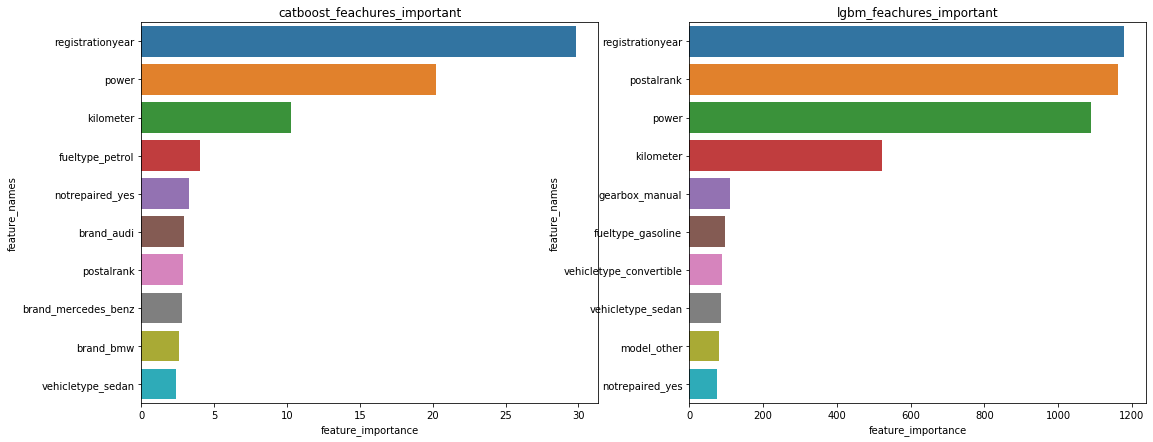

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 7))

sns.barplot(ax=axes[0],
    data=catboost_feachures_important,
    x="feature_importance", y="feature_names").set(title='catboost_feachures_important')

sns.barplot(ax=axes[1], 
    data=lgbm_feachures_important,
    x="feature_importance", y="feature_names").set(title='lgbm_feachures_important')



График топ 10 значимых факторов моделей catboost и  lgbm. Совпадение только по признаку года регистрации, в остальном моожели совершенно по разному определили значимость признаков. И кажеться что модель lgbm сделала это лучше. 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>отлично)

### Итоговый  результат

In [ ]:
results = pd.DataFrame()

In [ ]:
results = results.append(catboost_clear,ignore_index=True)

In [ ]:
results = results.append(lgbm,ignore_index=True)

In [ ]:
results = results.append(lin_r,ignore_index=True)

In [ ]:
results

,fit_score,fit_time,grid_score,grid_time,model,predict_time,result_score
0,1624.580537,0:01:28.752476,1729.625404,0:01:06.866642,Catboost,0:00:00.088639,1624.580537
1,1770.482753,0:00:17.703767,1770.482753,0:01:00.765031,LGBMRegressor,0:00:01.066813,1548.406709
2,NaN,0:00:04.678552,2512.272572,0:00:09.475708,LinearRegression,0:00:00.107004,2507.994656


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
<br/>Илья, крепкая работа<br>
Прочитав её до конца хочется добавить: ..."А по сему и делу конец), как говорится" <br>
Мне было интерено двигаться от блока к блоку, читать размышления, код и выводы.<br>
При этом оформление выводов такое же последовательное и адекватное.<br>
В целом, ты не забыл поисследовать данные, и достаточно разносторонне поработать с моделями.<br>
    
<font color='green'>
Если говорить, что можно ещё улучшить в подобных проектах, то я бы выделили такие моменты:<br>    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br>  
    
2) предварительная работа с данными:<br>
- На этом этапе нужно БОЛЬШЕ аргументации, для принимаемых решений.<br>
- Также, можно организовать для себя некую систему работы с данными:<br>
 
Например, алгоритм такой может:<br>
а) анализ аномалий: количественные и категориальные переменные <br>
б) анализ пропусков: количественные и категориальные переменные<br>
в) проверка дубликатов<br>
г) Анализ факторов: исходя из типа шкалы, могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
    
3) Можно попробовать провести анализ остатков. Вычислить разницу между прогноз-факт и посмотерть что и как можедель чаще всего хорошо/плохо предсказывает.<br>
4) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, суперретро, старая, новаоя... надо пдумать..) ну и попробовать новую модель (этопросто на обчуждение). А может, по каждому кластеру - вообще своя модель...<br>
    
    
<font color='red'>
Что ещё лучше сделать в этой работе:<br>
1) Очень здорово будет, если найдёшь возможность сделать график важности факторов. Это необходимая вещь для финалной части любой модельной работы.<br>
3) Если честно, то результаты лучше выводить в виде таблицы. Заказчику при презентации удобнее принимать решение, когда видна вся информация по моделям (метрика, время прогноза, время расчёта) в одном месте.
<font color='green'>    
<br>
Спасибо) БУДУ ЖДАТЬ КОММЕНТАРИЕВ!

<div style="background: #8aacc8; padding: 5px; border: 1px solid #0077c2; border-radius: 5px;">
Николай, спасибо за очень полезные и информативные коментарии, я их учер и исправил что смог)
Начну составять для себя проектный алгоритм, и изучу  дополнительно материал про остатки.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>Спасибо, Илья, за доработки.<br>
Ты прав -нужен алгоритм для себя, обязательно.<br>
Спасибо за проект) УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!

## Чек-лист проверки

Полученные данные были очищены от выбросов, удалены лишние признаки, не несущие в себе никакой значимости для целевого признака.
После первоначальной обработки было сформированно два датасет для обучения моделей. Оба датасета сократились порядка на 40 000 событий.
1. Датасет в котором все пропуски были заменены на "other", размер датасета остался не изменым после первого этапа обработки
2. Датасет был полностью очищен от событий с пропусками, размер сократился еще порядка на 15 процентов от этапа обработки

В таком виде выборки были переданы на второй этап - обучение моделей, и выбора датасета для тестирования и обучения.
В качестве первой модели обучения была модель catboostRegressor, с ее помощью предполагалось выбрать наилучший датасет.
После первых попыток, в выборках были перекодированы категориальные признаки, что ускорило время обучения.

Для моделей lgbm, catboost для проверки использовалась тестовая выборка.

Подбор параметров для моделей catboost подбирался методом gred_search на 1 итерации.  Параметр learning_rate.Не уверен что данный параметр удалось подобрать корректно на 5 итерациях. Увеличение кол-ва итераций сильно увеличивает время подбора параметров.

По полученным параметрам, с небольшим отрывом от показателей модели catboost, в скорости, и  существенным в значении метрики, лучшей показала себя модель lgbm.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей